In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
from google.cloud import bigquery
from google.oauth2 import service_account

# TODO(developer): Set key_path to the path to the service account key
#                  file.
key_path="C:\\Users\\fachreddin\\Dropbox\\datascience\\kaggle-test-1cfdbf99ef9a.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)
PROJECT_ID = credentials.project_id

In [9]:
# Creating a reference of our table
table = client.get_table("bigquery-public-data.openaq.global_air_quality")

# Looking at the first five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [10]:
# Checking the number of measure station in each country
query = """SELECT country, COUNT(location) AS number_of_locations
                FROM `bigquery-public-data.openaq.global_air_quality`
                GROUP BY country
                ORDER by number_of_locations DESC"""

query_job = client.query(query)
query_job.to_dataframe().head(10)

,country,number_of_locations
0,US,3723
1,ES,2123
2,FR,1608
3,IN,1531
4,DE,1455
5,IT,1334
6,PL,929
7,AT,917
8,CL,499
9,TR,497


In [11]:
# Statistics Summary
query = """SELECT value,averaged_over_in_hours
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE unit = 'µg/m³'
            """
query_job = client.query(query)
query_job.to_dataframe().describe()

,value,averaged_over_in_hours
count,17699.000000,16271.000000
mean,96.221432,1.734780
std,6762.903121,4.390985
min,-335582.000000,0.250000
25%,5.000000,1.000000
50%,12.800000,1.000000
75%,37.000000,1.000000
max,825736.000000,59.000000


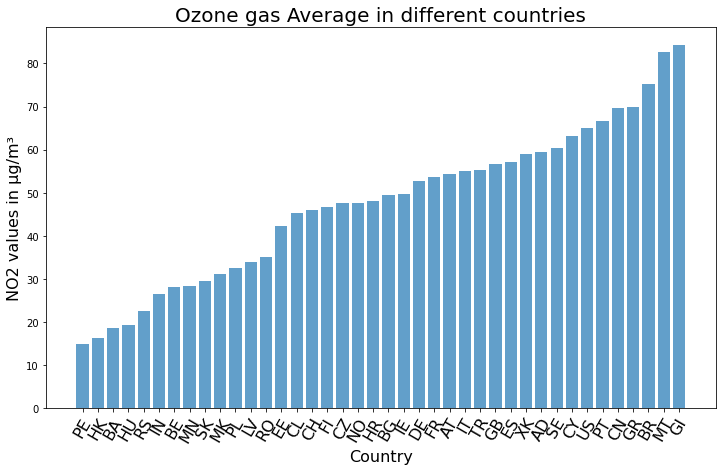

In [12]:
# Calculating the average value of Ozone Gas in each different country
query = """
    SELECT
        country, 
        avg(value) as avg_value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'o3'
      AND country != 'NL'
      AND country != 'DK'
      AND country != 'LT'
      AND country != 'LU'
      AND unit = 'µg/m³'
    GROUP BY country
    ORDER BY avg_value ASC
        """

query_job = client.query(query)
query_df = query_job.to_dataframe()

plt.subplots(figsize=(12,7))
y_pos = np.arange(len(query_df.country))
plt.bar(y_pos, query_df.avg_value, align='center', alpha=0.7)
plt.xticks(y_pos, query_df.country.values)

plt.ylabel('NO2 values in µg/m³', fontsize=16)
plt.xticks(rotation= 60,fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.title('Ozone gas Average in different countries', fontsize=20)
plt.show()

In [13]:
#Machine Learning
from google.cloud.bigquery import magics
#from kaggle.gcp import KaggleKernelCredentials
#magics.context.credentials = KaggleKernelCredentials()
magics.context.credentials = credentials
magics.context.project = PROJECT_ID
%load_ext google.cloud.bigquery

In [14]:
%%bigquery
CREATE MODEL IF NOT EXISTS `tds_tutorial.Model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  country AS label, latitude, longitude, value 
FROM
  `bigquery-public-data.openaq.global_air_quality`
LIMIT 800;

""


In [15]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `tds_tutorial.Model`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.618634,0.618763,0.2,2626
1,0,1,0.499952,0.500093,0.4,2770
2,0,2,0.345394,0.345386,0.8,2607
3,0,3,0.196564,0.196372,1.6,2925
4,0,4,0.096379,0.096073,3.2,2501
5,0,5,0.045398,0.045109,6.4,2529
6,0,6,0.021760,0.021543,12.8,3513
7,0,7,0.010647,0.010503,25.6,2343
8,0,8,0.005278,0.005188,51.2,2722
9,0,9,0.002635,0.002582,102.4,2501


In [16]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `tds_tutorial.Model`, (
SELECT
  country AS label, latitude, longitude, value 
FROM
  `bigquery-public-data.openaq.global_air_quality`
LIMIT 800))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,1.0,1.0,1.0,0.000003,1.0
